### Q24 Q25

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import SVD, evaluate
from surprise import NMF
from surprise.model_selection import cross_validate
from surprise import Dataset
from surprise import Reader
import os
from surprise.model_selection import train_test_split
ratings = pd.read_csv('ratings.csv') # reading data in pandas df
from surprise import Reader, Dataset
# to load dataset from pandas df, we need `load_fromm_df` method in surprise lib
ratings_dict = {'itemID': list(ratings.movieId),
                'userID': list(ratings.userId),
                'rating': list(ratings.rating)}
df = pd.DataFrame(ratings_dict)
# A reader is still needed but only the rating_scale param is required.
# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(0.5, 5.0))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader) 

In [3]:

MF_RMSE=[];
MF_MAE=[];
latent_factors=np.arange(2,51,2)
print("doing cross validation...")
for k in latent_factors:
    algo=SVD(n_factors=k,biased=True,random_state=42)
    cv_results=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False);
    MF_RMSE.append(np.mean(cv_results['test_rmse']))
    MF_MAE.append(np.mean(cv_results['test_mae']))

print("cross validation completed")  

doing cross validation...
cross validation completed


### Q24 25

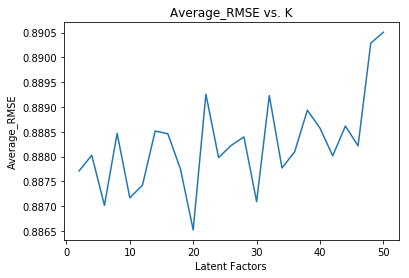

The min average_rmse is 0.886521
corresponding k= 20


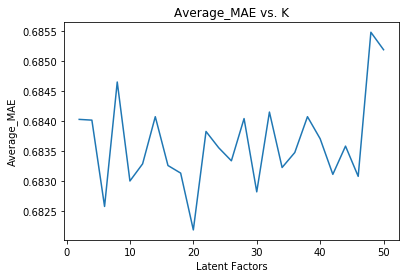

The min average_mae is 0.682190
The corresponding k= 20


In [4]:
plt.plot(latent_factors,MF_RMSE)
plt.xlabel('Latent Factors')
plt.ylabel('Average_RMSE')
plt.title('Average_RMSE vs. K')
plt.show()
print("The min average_rmse is %6f" %min(MF_RMSE))
index_min=np.argmin(MF_RMSE)
k_value=latent_factors[index_min]
print("corresponding k= %d"%k_value)


plt.plot(latent_factors,MF_MAE)
plt.xlabel('Latent Factors')
plt.ylabel('Average_MAE')
plt.title('Average_MAE vs. K')
plt.show()
print("The min average_mae is %6f" %min(MF_MAE))
index_min=np.argmin(MF_MAE)
k_value=latent_factors[index_min]
print("The corresponding k= %d"%k_value)

In [5]:
from surprise import accuracy
from surprise.model_selection import KFold
from collections import defaultdict

def trimming_function(trim_method, test_data_set):
    #build a dictionary to store the movieID and corrsponding ratings
    # rating_dict[movieID]=the list of its ratings     
    trimmed=[] 
    rating_dict=defaultdict(list)
    for i in range(len(test_data_set)):
        rating_dict[test_data_set[i][1]].append(test_data_set[i][2])
    
    if(trim_method=='Popular'):
        for i in range(len(test_data_set)):
            if(len(rating_dict[test_data_set[i][1]])>2):
                trimmed.append(test_data_set[i])
                
    elif(trim_method=='Unpopular'):
        for i in range(len(test_data_set)):
            if(len(rating_dict[test_data_set[i][1]])<=2):
                trimmed.append(test_data_set[i])   
                
    elif(trim_method=='High_variance'):          
        # test the variance of each movie ratings, remove the movie from dict if variance<2
        for i in range(len(test_data_set)):
            if(len(rating_dict[test_data_set[i][1]])<5 or np.var(rating_dict[test_data_set[i][1]])<2):
                del rating_dict[test_data_set[i][1]]
                
        for i in range(len(test_data_set)):
            if(test_data_set[i][1] in list(rating_dict.keys())):
                trimmed.append(test_data_set[i])
    else:
        print('ERROR!')
        return
        
    return trimmed

def MF_cross_validation_function(data_set,latent_factor,trim_method):
    kf=KFold(n_splits=10,random_state=42)
    algo=SVD(n_factors=latent_factor, biased=True,random_state=42)
    RMSE_set=[]
    for trainset, testset in kf.split(data_set):
        algo.fit(trainset)
        trimmed_testset=trimming_function(trim_method, testset)
        predictions=algo.test(trimmed_testset)
        RMSE_set.append(accuracy.rmse(predictions, verbose=False))
        
    Average_RMSR=np.mean(RMSE_set)
    return Average_RMSR
    

def MF_RMSE_plot(latent_factors, NNMF_RMSE, trim_method):
    print('MF polt for %s movies trimmed test set'% trim_method)
    plt.plot(latent_factors,NNMF_RMSE)
    plt.xlabel('Latent Factors')
    plt.ylabel('Average_RMSE')
    plt.title('Average_RMSE vs. K')
    plt.show()
    print("The min average_rmse is %6f" %min(NNMF_RMSE))
    min_index=np.argmin(NNMF_RMSE)
    lf=latent_factors[min_index]
    print("The corresponding k= %d" %lf)
    print('')

### Q26 27 28

Doing MF with bias on Popular movies trimmed test set....
MF polt for Popular movies trimmed test set


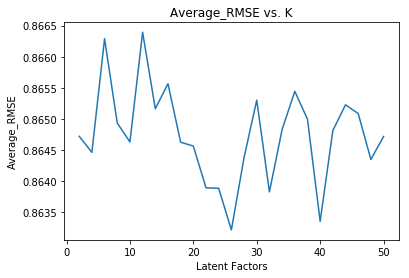

The min average_rmse is 0.863211
The corresponding k= 26

Doing MF with bias on Unpopular movies trimmed test set....
MF polt for Unpopular movies trimmed test set


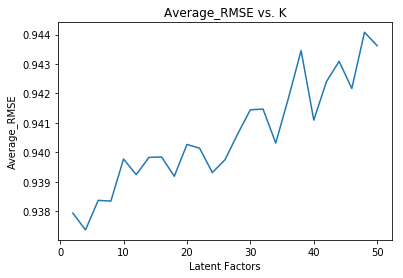

The min average_rmse is 0.937360
The corresponding k= 4

Doing MF with bias on High_variance movies trimmed test set....
MF polt for High_variance movies trimmed test set


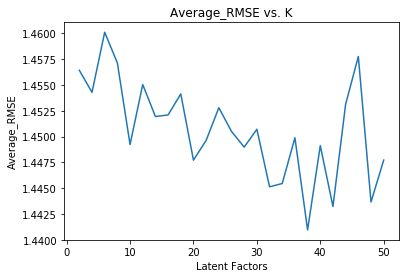

The min average_rmse is 1.440978
The corresponding k= 38



In [8]:
latent_factors=np.arange(2,51,2)
trimming_operations=['Popular','Unpopular','High_variance']
for method in trimming_operations:
    print("Doing MF with bias on %s movies trimmed test set...." %method)
    Average_RMSR_set=[]
    for k in latent_factors:
        Average_RMSR_set.append(MF_cross_validation_function(data,k,method))
        
    MF_RMSE_plot(latent_factors,Average_RMSR_set,method)

### Q29

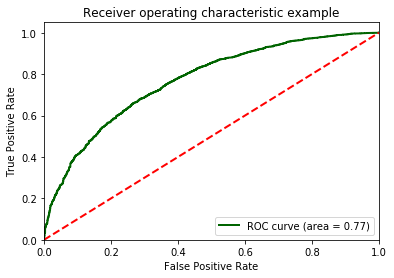

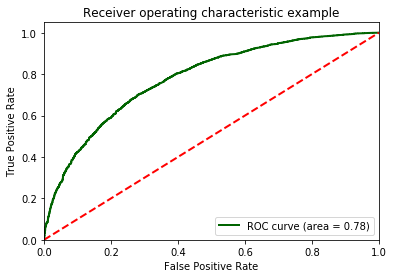

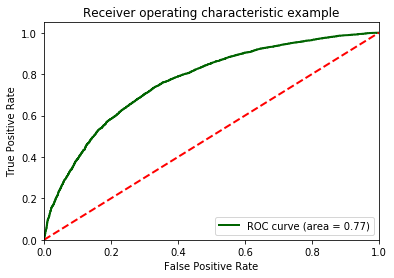

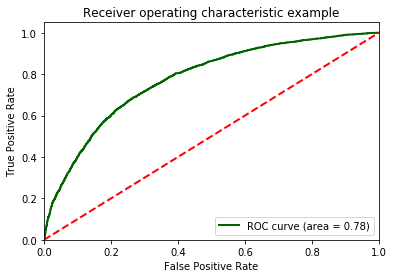

In [9]:
train_set, test_set = train_test_split(data, test_size=0.1)
algo=SVD(n_factors=20,biased=True,random_state=42)
algo.fit(train_set)
predictions = algo.test(test_set)

test_target_group = []
score_test = []
for (_, _, true_r, est, _) in predictions:
    test_target_group.append(true_r)
    score_test.append(est)
    
def threshold_target(threshold,test_target_group):
    aft_test = []
    for i in test_target_group:
        if i>= threshold: k = 1
        else: k=0
        aft_test.append(k)
    return aft_test
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# calculate ROC curve and ROC area for each class


def plot_roc(fpr, tpr):   
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkgreen',lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

for threshold in [2.5,3,3.5,4]:
    aft_test = threshold_target(threshold,test_target_group)
    fpr = dict()
    tpr = dict()
    fpr, tpr, thresholds = roc_curve(aft_test, score_test)
    plot_roc(fpr, tpr)

## 7 Performance comparison 
### Q34

Computing the pearson similarity matrix...
Done computing similarity matrix.


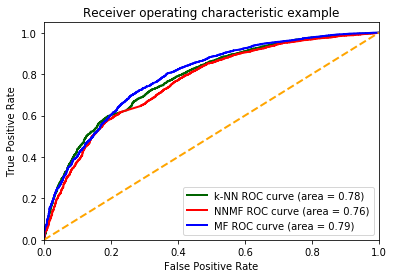

In [54]:
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
import os
from surprise.prediction_algorithms.knns import KNNWithMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import SVD, evaluate
from surprise import NMF
from surprise.model_selection import cross_validate

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def threshold_target(threshold,test_target_group):
    aft_test = []
    for i in test_target_group:
        if i>= threshold: k = 1
        else: k=0
        aft_test.append(k)
    return aft_test

def plot_three_roc(fpr1, tpr1,fpr2, tpr2,fpr3, tpr3):   
    roc_auc1 = auc(fpr1, tpr1)
    roc_auc2 = auc(fpr2, tpr2)
    roc_auc3 = auc(fpr3, tpr3)
    plt.figure()
    plt.plot(fpr1, tpr1, color='darkgreen',lw=2, label='k-NN ROC curve (area = %0.2f)' % roc_auc1)    
    plt.plot(fpr2, tpr2, color='red',lw=2, label='NNMF ROC curve (area = %0.2f)' % roc_auc2)
    plt.plot(fpr3, tpr3, color='blue',lw=2, label='MF ROC curve (area = %0.2f)' % roc_auc3)
    
    plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


# path to dataset file
file_path = os.path.expanduser('C:/python/EE219/project3/ratings.csv')

# 'user item rating timestamp', separated by ',' characters. skip the first line with header
reader = Reader(line_format='user item rating timestamp', sep=',',skip_lines=1)
#split the dataset into 90% for training and 10% for testing
data = Dataset.load_from_file(file_path, reader=reader)
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.10)
# We'll use the KNNWithMeans algorithm.
sim_options = {'name': 'pearson'}
algo1 = KNNWithMeans(k = 35, sim_options = sim_options)
# Train the algorithm on the trainset, and predict ratings for the testset
algo1.fit(trainset)
predictions1 = algo1.test(testset)

trainset, testset = train_test_split(data, test_size=.10)
algo2=NMF(n_factors=20,biased=False,random_state=42)
algo2.fit(trainset)
predictions2 = algo2.test(testset)

trainset, testset = train_test_split(data, test_size=.10)
algo3=SVD(n_factors=20,biased=True,random_state=42)
algo3.fit(trainset)
predictions3 = algo3.test(testset)




test_target_group1 = []
score_test1 = []
for (_, _, true_r, est, _) in predictions1:
    test_target_group1.append(true_r)
    score_test1.append(est)

test_target_group2 = []
score_test2 = []
for (_, _, true_r, est, _) in predictions2:
    test_target_group2.append(true_r)
    score_test2.append(est)
    
    
test_target_group3 = []
score_test3 = []
for (_, _, true_r, est, _) in predictions3:
    test_target_group3.append(true_r)
    score_test3.append(est)


#roc for knn
threshold = 3
aft_test1 = threshold_target(threshold,test_target_group1)
fpr1 = dict()
tpr1 = dict()
fpr1, tpr1, thresholds = roc_curve(aft_test1, score_test1)

#roc for nnmf
aft_test2 = threshold_target(threshold,test_target_group2)
fpr2 = dict()
tpr2 = dict()
fpr2, tpr2, thresholds = roc_curve(aft_test2, score_test2)

#roc for mf
aft_test3 = threshold_target(threshold,test_target_group3)
fpr3 = dict()
tpr3 = dict()
fpr3, tpr3, thresholds = roc_curve(aft_test3, score_test3)



plot_three_roc(fpr1, tpr1,fpr2, tpr2,fpr3, tpr3)

## 8 Ranking

In [71]:
from collections import defaultdict
from surprise import Dataset
from surprise import SVD
from surprise.model_selection import KFold


def precision_recall_at_k(predictions, k, threshold=3):
    '''Return precision and recall at k metrics for each user.'''
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    for uid, user_ratings in list(user_est_true.items()):
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        if n_rel==0:
            del user_est_true[uid]
    
    for uid, user_ratings in list(user_est_true.items()):
        if len(user_est_true[uid])<k:
            del user_est_true[uid] 
    
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)   
        # Number of relevant items : G
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k]) 
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1 
    return precisions, recalls


def GetMean_prec_rec(k,algo,data):
    prec=[]
    rec=[]
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3)
        # Precision and recall can then be averaged over all users
        prec.append(sum(prec for prec in precisions.values()) / len(precisions))
        rec.append(sum(rec for rec in recalls.values()) / len(recalls))
    prec_mean = np.mean(prec)
    rec_mean = np.mean(rec)
    return prec_mean,rec_mean

file_path = os.path.expanduser('C:/python/EE219/project3/ratings.csv')
reader = Reader(line_format='user item rating timestamp', sep=',',skip_lines=1)
data = Dataset.load_from_file(file_path, reader=reader)


kf = KFold(n_splits=10)
algo = KNNWithMeans(k = 35, sim_options = sim_options)


prec = []
rec = []
for k in range(1,26):
    prec_mean,rec_mean = GetMean_prec_rec(k,algo,data)
    prec.append(prec_mean)
    rec.append(rec_mean)
print(prec)
print(rec)


Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

### Q36

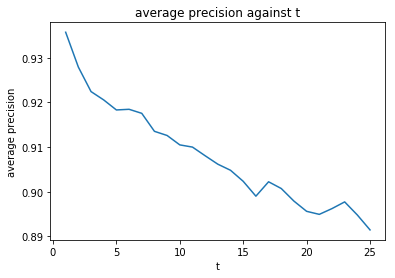

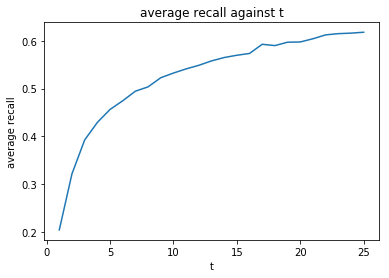

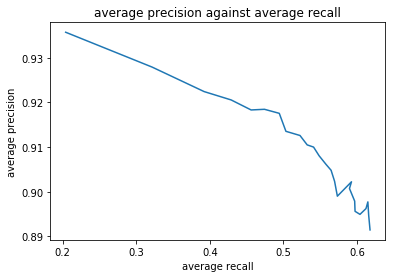

In [72]:

k = range(1,26)

plt.figure()
plt.plot(k,prec)
plt.xlabel("t")
plt.ylabel("average precision")
plt.title("average precision against t")
plt.show()

plt.figure()
plt.plot(k,rec)
plt.xlabel("t")
plt.ylabel("average recall")
plt.title("average recall against t")
plt.show()

plt.figure()
plt.plot(rec, prec)
plt.xlabel("average recall")
plt.ylabel("average precision")
plt.title("average precision against average recall")
plt.show()

### Q37

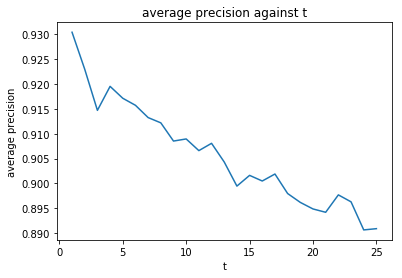

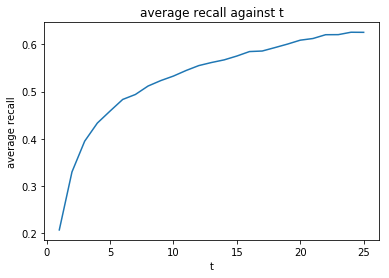

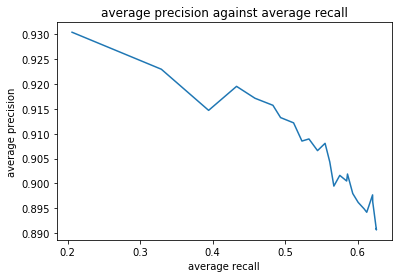

In [73]:
kf = KFold(n_splits=10)
algo2=NMF(n_factors=20,biased=False,random_state=42)


prec2 = []
rec2 = []
for k in range(1,26):
    prec_mean2,rec_mean2 = GetMean_prec_rec(k,algo2,data)
    prec2.append(prec_mean2)
    rec2.append(rec_mean2)

k = range(1,26)

plt.figure()
plt.plot(k,prec2)
plt.xlabel("t")
plt.ylabel("average precision")
plt.title("average precision against t")
plt.show()

plt.figure()
plt.plot(k,rec2)
plt.xlabel("t")
plt.ylabel("average recall")
plt.title("average recall against t")
plt.show()

plt.figure()
plt.plot(rec2, prec2)
plt.xlabel("average recall")
plt.ylabel("average precision")
plt.title("average precision against average recall")
plt.show()

### Q38

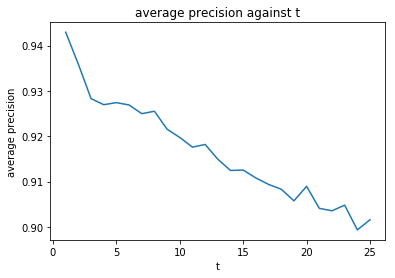

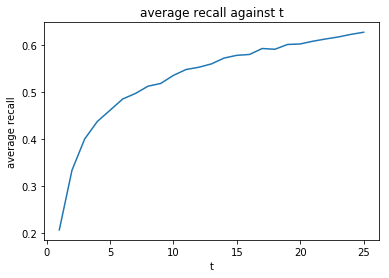

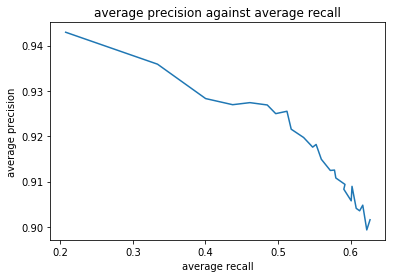

In [74]:
kf = KFold(n_splits=10)
algo3=SVD(n_factors=20,biased=True,random_state=42)


prec3 = []
rec3 = []
for k in range(1,26):
    prec_mean3,rec_mean3 = GetMean_prec_rec(k,algo3,data)
    prec3.append(prec_mean3)
    rec3.append(rec_mean3)

k = range(1,26)

plt.figure()
plt.plot(k,prec3)
plt.xlabel("t")
plt.ylabel("average precision")
plt.title("average precision against t")
plt.show()

plt.figure()
plt.plot(k,rec3)
plt.xlabel("t")
plt.ylabel("average recall")
plt.title("average recall against t")
plt.show()

plt.figure()
plt.plot(rec3, prec3)
plt.xlabel("average recall")
plt.ylabel("average precision")
plt.title("average precision against average recall")
plt.show()

### Q39

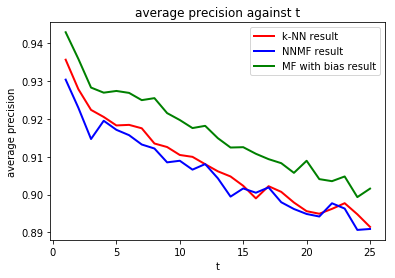

In [79]:
plt.figure()    
plt.plot(k, prec, color='red',lw=2, label='k-NN result')
plt.plot(k, prec2, color='blue',lw=2, label='NNMF result')
plt.plot(k, prec3, color='green',lw=2, label='MF with bias result')
plt.xlabel("t")
plt.ylabel("average precision")
plt.title("average precision against t")
plt.legend(loc="upper right")
plt.show()

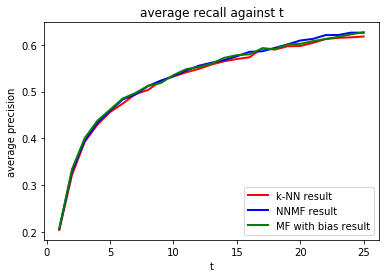

In [82]:
plt.figure()    
plt.plot(k, rec, color='red',lw=2, label='k-NN result')
plt.plot(k, rec2, color='blue',lw=2, label='NNMF result')
plt.plot(k, rec3, color='green',lw=2, label='MF with bias result')
plt.xlabel("t")
plt.ylabel("average precision")
plt.title("average recall against t")
plt.legend(loc="lower right")
plt.show()


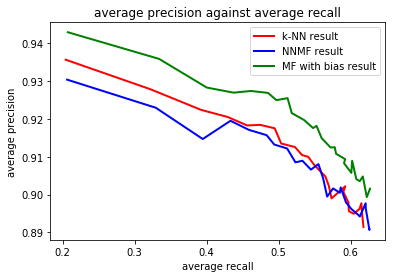

In [84]:
plt.figure()    
plt.plot(rec, prec, color='red',lw=2, label='k-NN result')
plt.plot(rec2, prec2, color='blue',lw=2, label='NNMF result')
plt.plot(rec3, prec3, color='green',lw=2, label='MF with bias result')
plt.xlabel("average recall")
plt.ylabel("average precision")
plt.title("average precision against average recall")
plt.legend(loc="upper right")
plt.show()